In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

In [2]:
FILE_PATH_1 = 'robot1_with_hard_detection_trial_1.csv'
FILE_PATH_2 = 'robot2_with_hard_detection_trial_1.csv'

In [3]:
N_COLUMNS = 36 # should infer from df number of columns

ROBOT_INFO_SIZE = 3
DETECTION_INFO_SIZE = 1
CLUSTER_INFO_SIZE = 4

N_CLUSTERS = int((N_COLUMNS - ROBOT_INFO_SIZE - DETECTION_INFO_SIZE) / CLUSTER_INFO_SIZE)

# Load Data

In [4]:
def load_robot_data(file_path):
    df = pd.read_csv(file_path, header=None)
    column_names = ['robot_x', 'robot_y', 'robot_angle']
    for i in range(N_CLUSTERS):
        column_names.extend([f'cluster{i}_x', f'cluster{i}_y', f'cluster{i}_angle', f'cluster{i}_weight'])
    column_names.append('has_detection')
    df.columns = column_names
    return df
    
df_robot1 = load_robot_data(FILE_PATH_1)
df_robot2 = load_robot_data(FILE_PATH_2)

# Clusters error

In [5]:
def compute_clusters_errors(df):
    for cluster_id in range(N_CLUSTERS):
        diff_x_square = (df[f"robot_x"] - df[f"cluster{cluster_id}_x"])**2
        diff_y_square = (df[f"robot_y"] - df[f"cluster{cluster_id}_y"])**2
        df[f"cluster{cluster_id}_error"] = np.sqrt(diff_x_square + diff_y_square)
    return df


df_robot1 = compute_clusters_errors(df_robot1)
df_robot2 = compute_clusters_errors(df_robot2)

In [6]:
EXPERIMENT_TIME_S = 310
CELLS_TO_METERS = 10

def _cells_to_meters(cells):
    return cells / CELLS_TO_METERS

## Top N (accumulated) clusters error

<IPython.core.display.Javascript object>


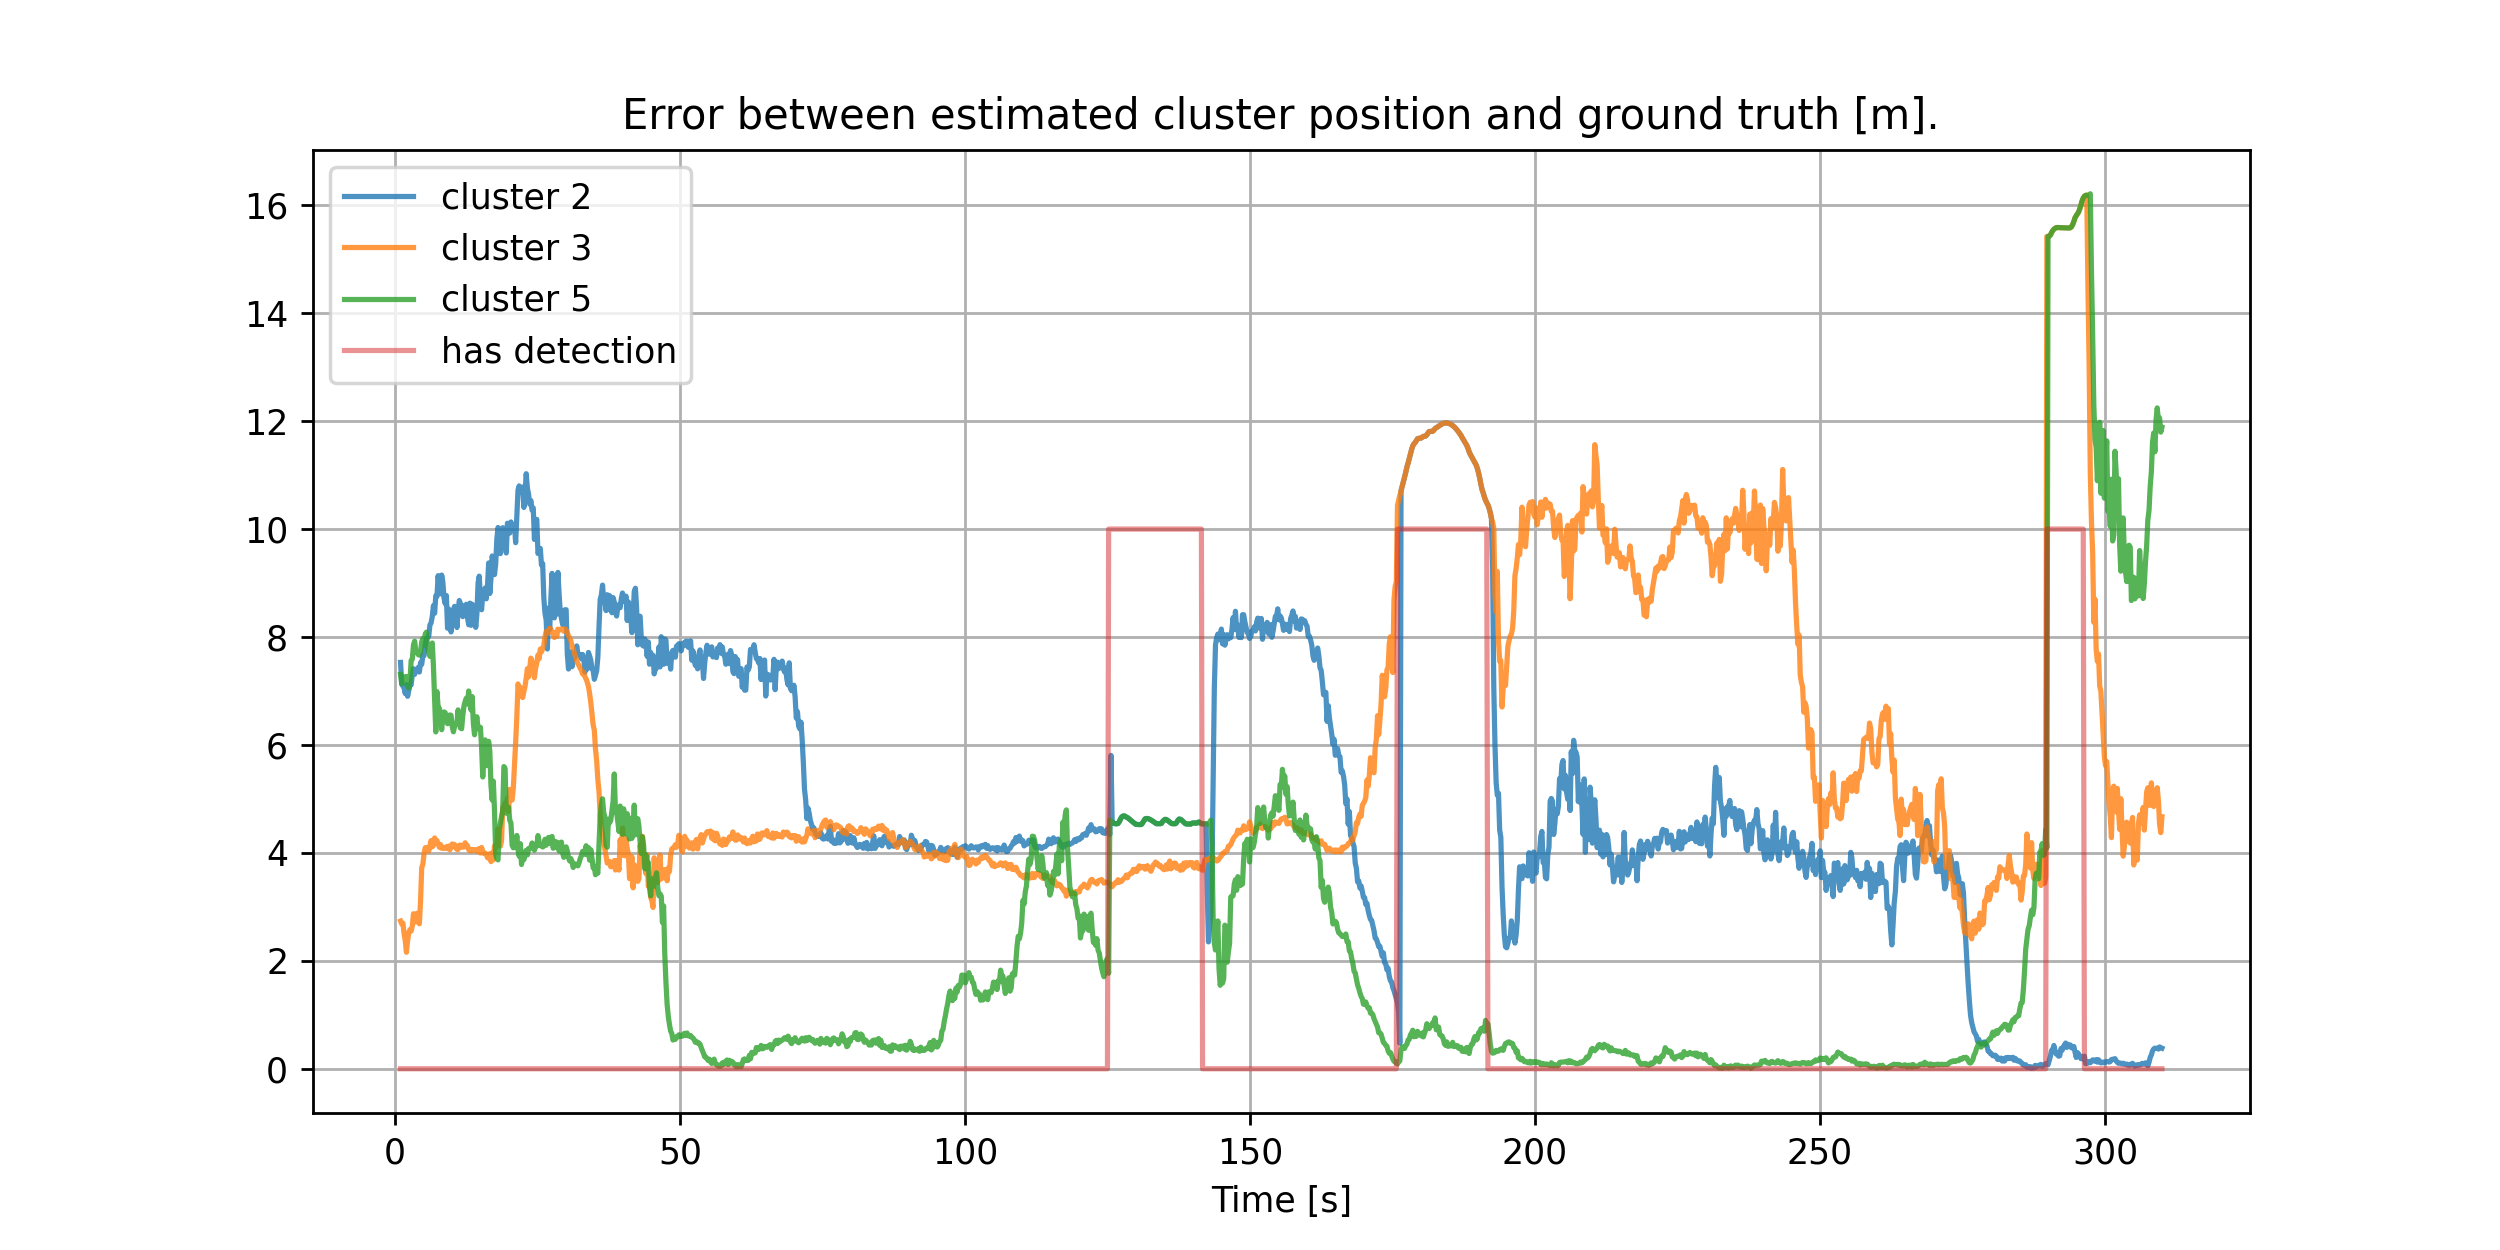

<IPython.core.display.Javascript object>


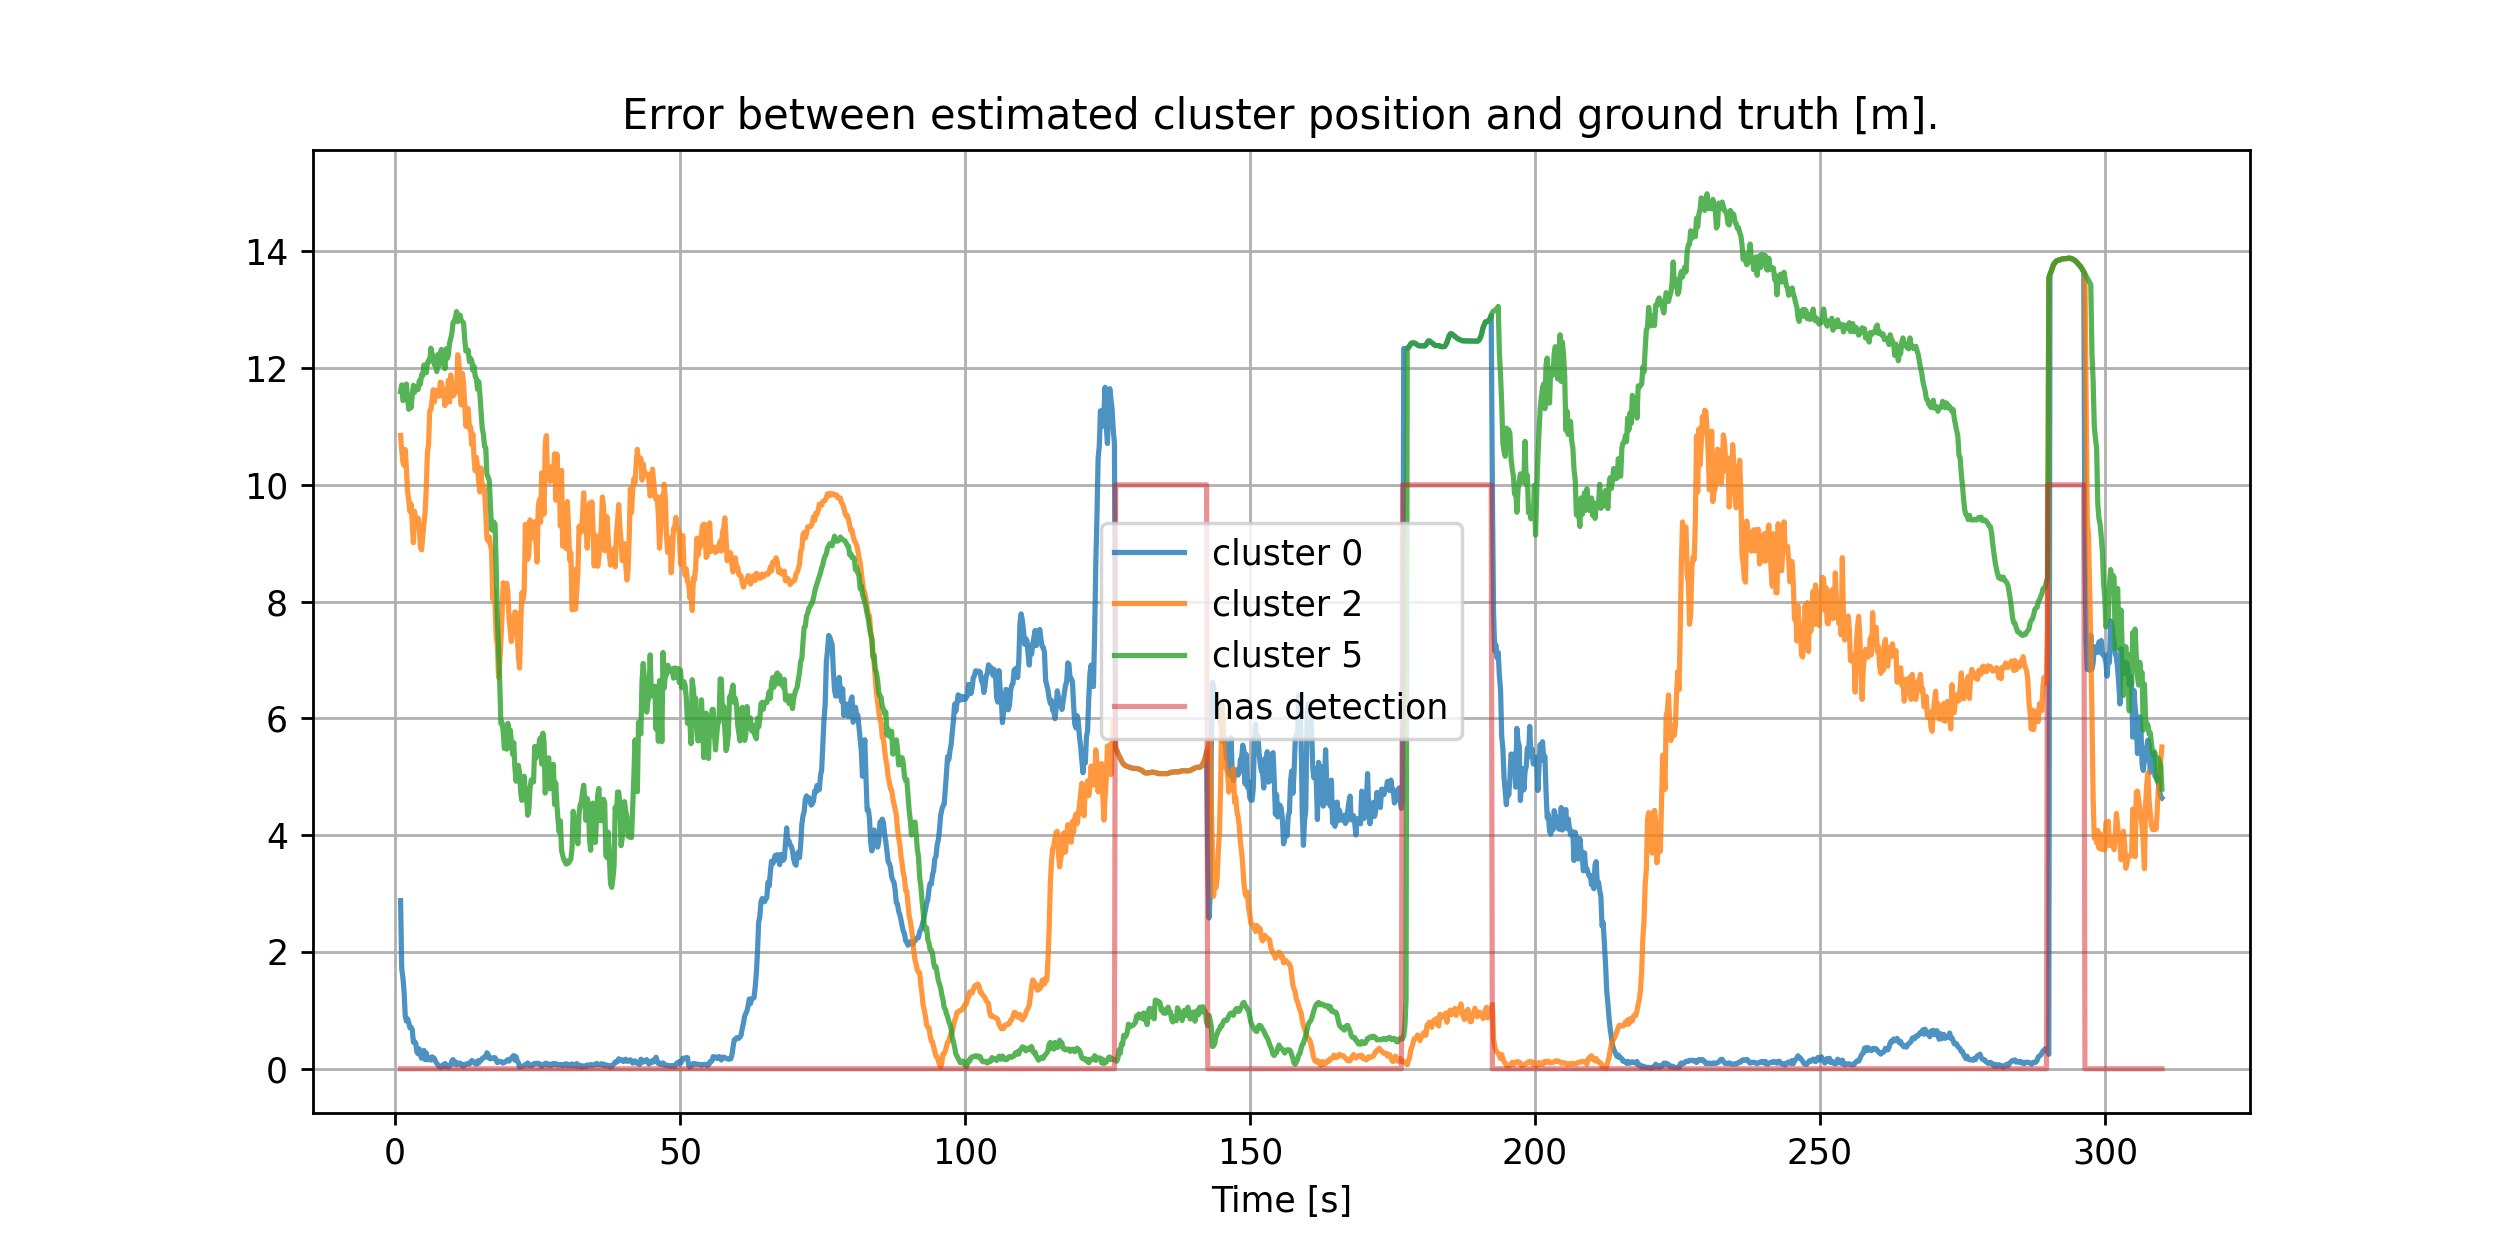

In [7]:
def plot_top_n_accumulated_cluster_errors(df):
    t = np.linspace(1, EXPERIMENT_TIME_S, len(df))

    N_CLUSTERS_TO_PLOT = 3
    plt.figure(figsize=(10, 5), facecolor='w')
    plt.title('Error between estimated cluster position and ground truth [m].')

    weights = []
    for cluster_id in range(N_CLUSTERS):
        df[f"cluster{cluster_id}_w_mean"] = df[f"cluster{cluster_id}_weight"].mean()
        weights.append(df[f"cluster{cluster_id}_w_mean"].iloc[0])

    weights_to_plot = sorted(weights, reverse=True)[:N_CLUSTERS_TO_PLOT]
    for cluster_id in range(N_CLUSTERS):
        weight = df[f"cluster{cluster_id}_w_mean"].iloc[0]
        if weight in weights_to_plot: 
            plt.plot(t, _cells_to_meters(
                df[f"cluster{cluster_id}_error"]), alpha=0.8, label=f"cluster {cluster_id}")

    plt.plot(t, df.has_detection * 10, alpha=0.5, label="has detection")
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_top_n_accumulated_cluster_errors(df_robot1)
plot_top_n_accumulated_cluster_errors(df_robot2)

## Best (instantaneous) cluster error

<IPython.core.display.Javascript object>


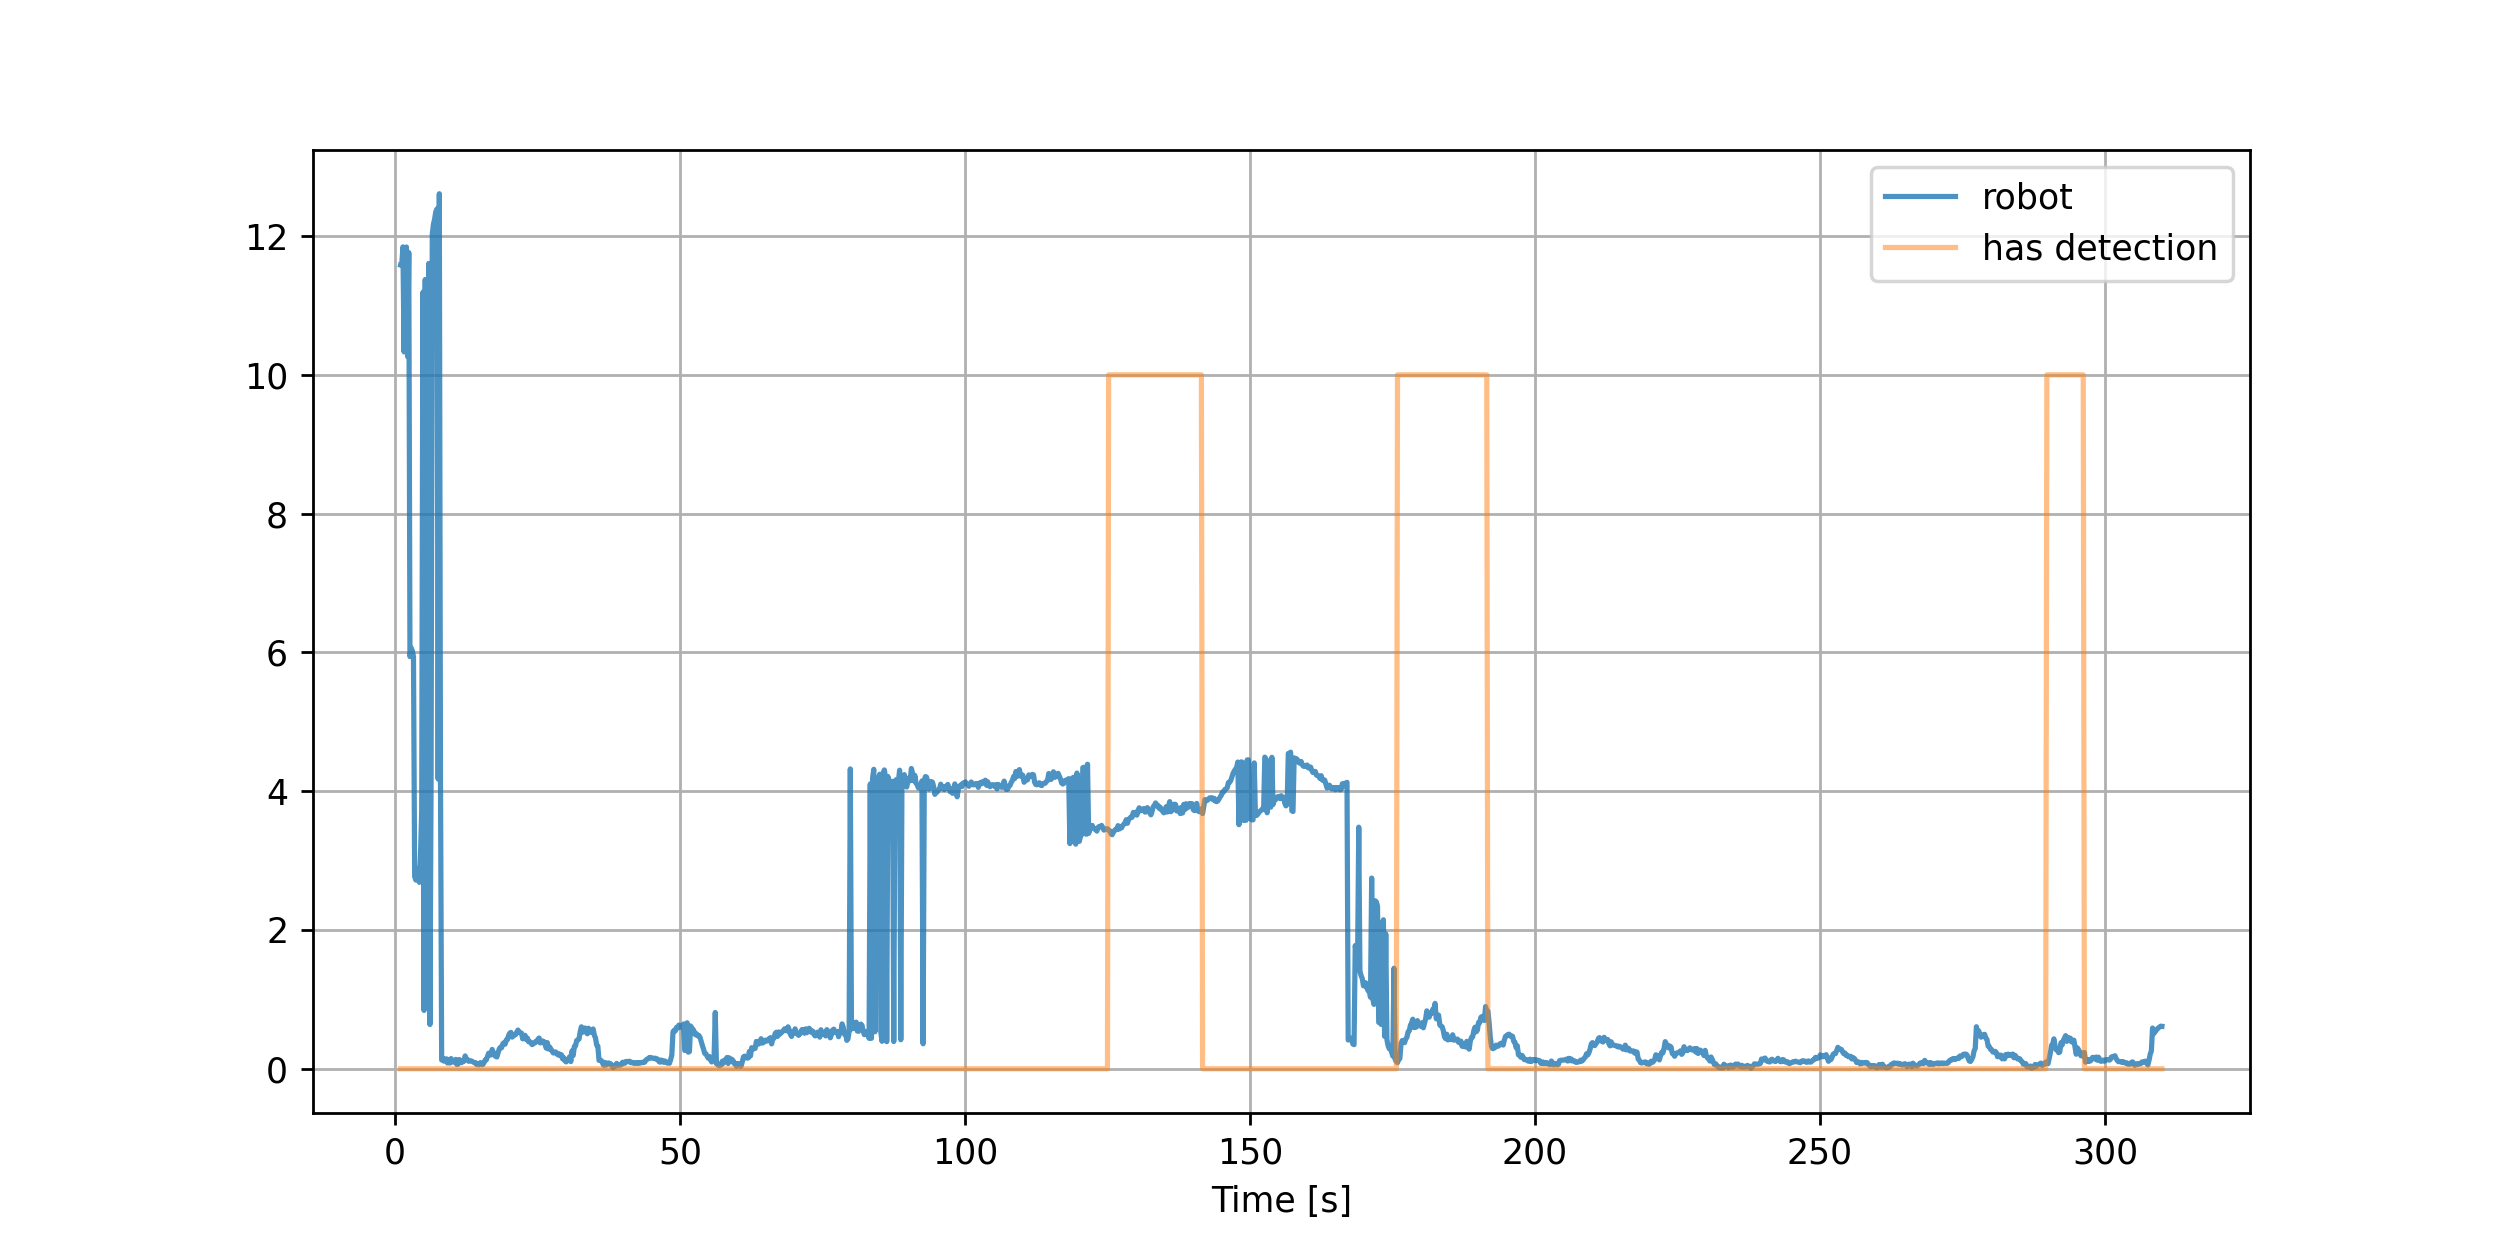

<IPython.core.display.Javascript object>


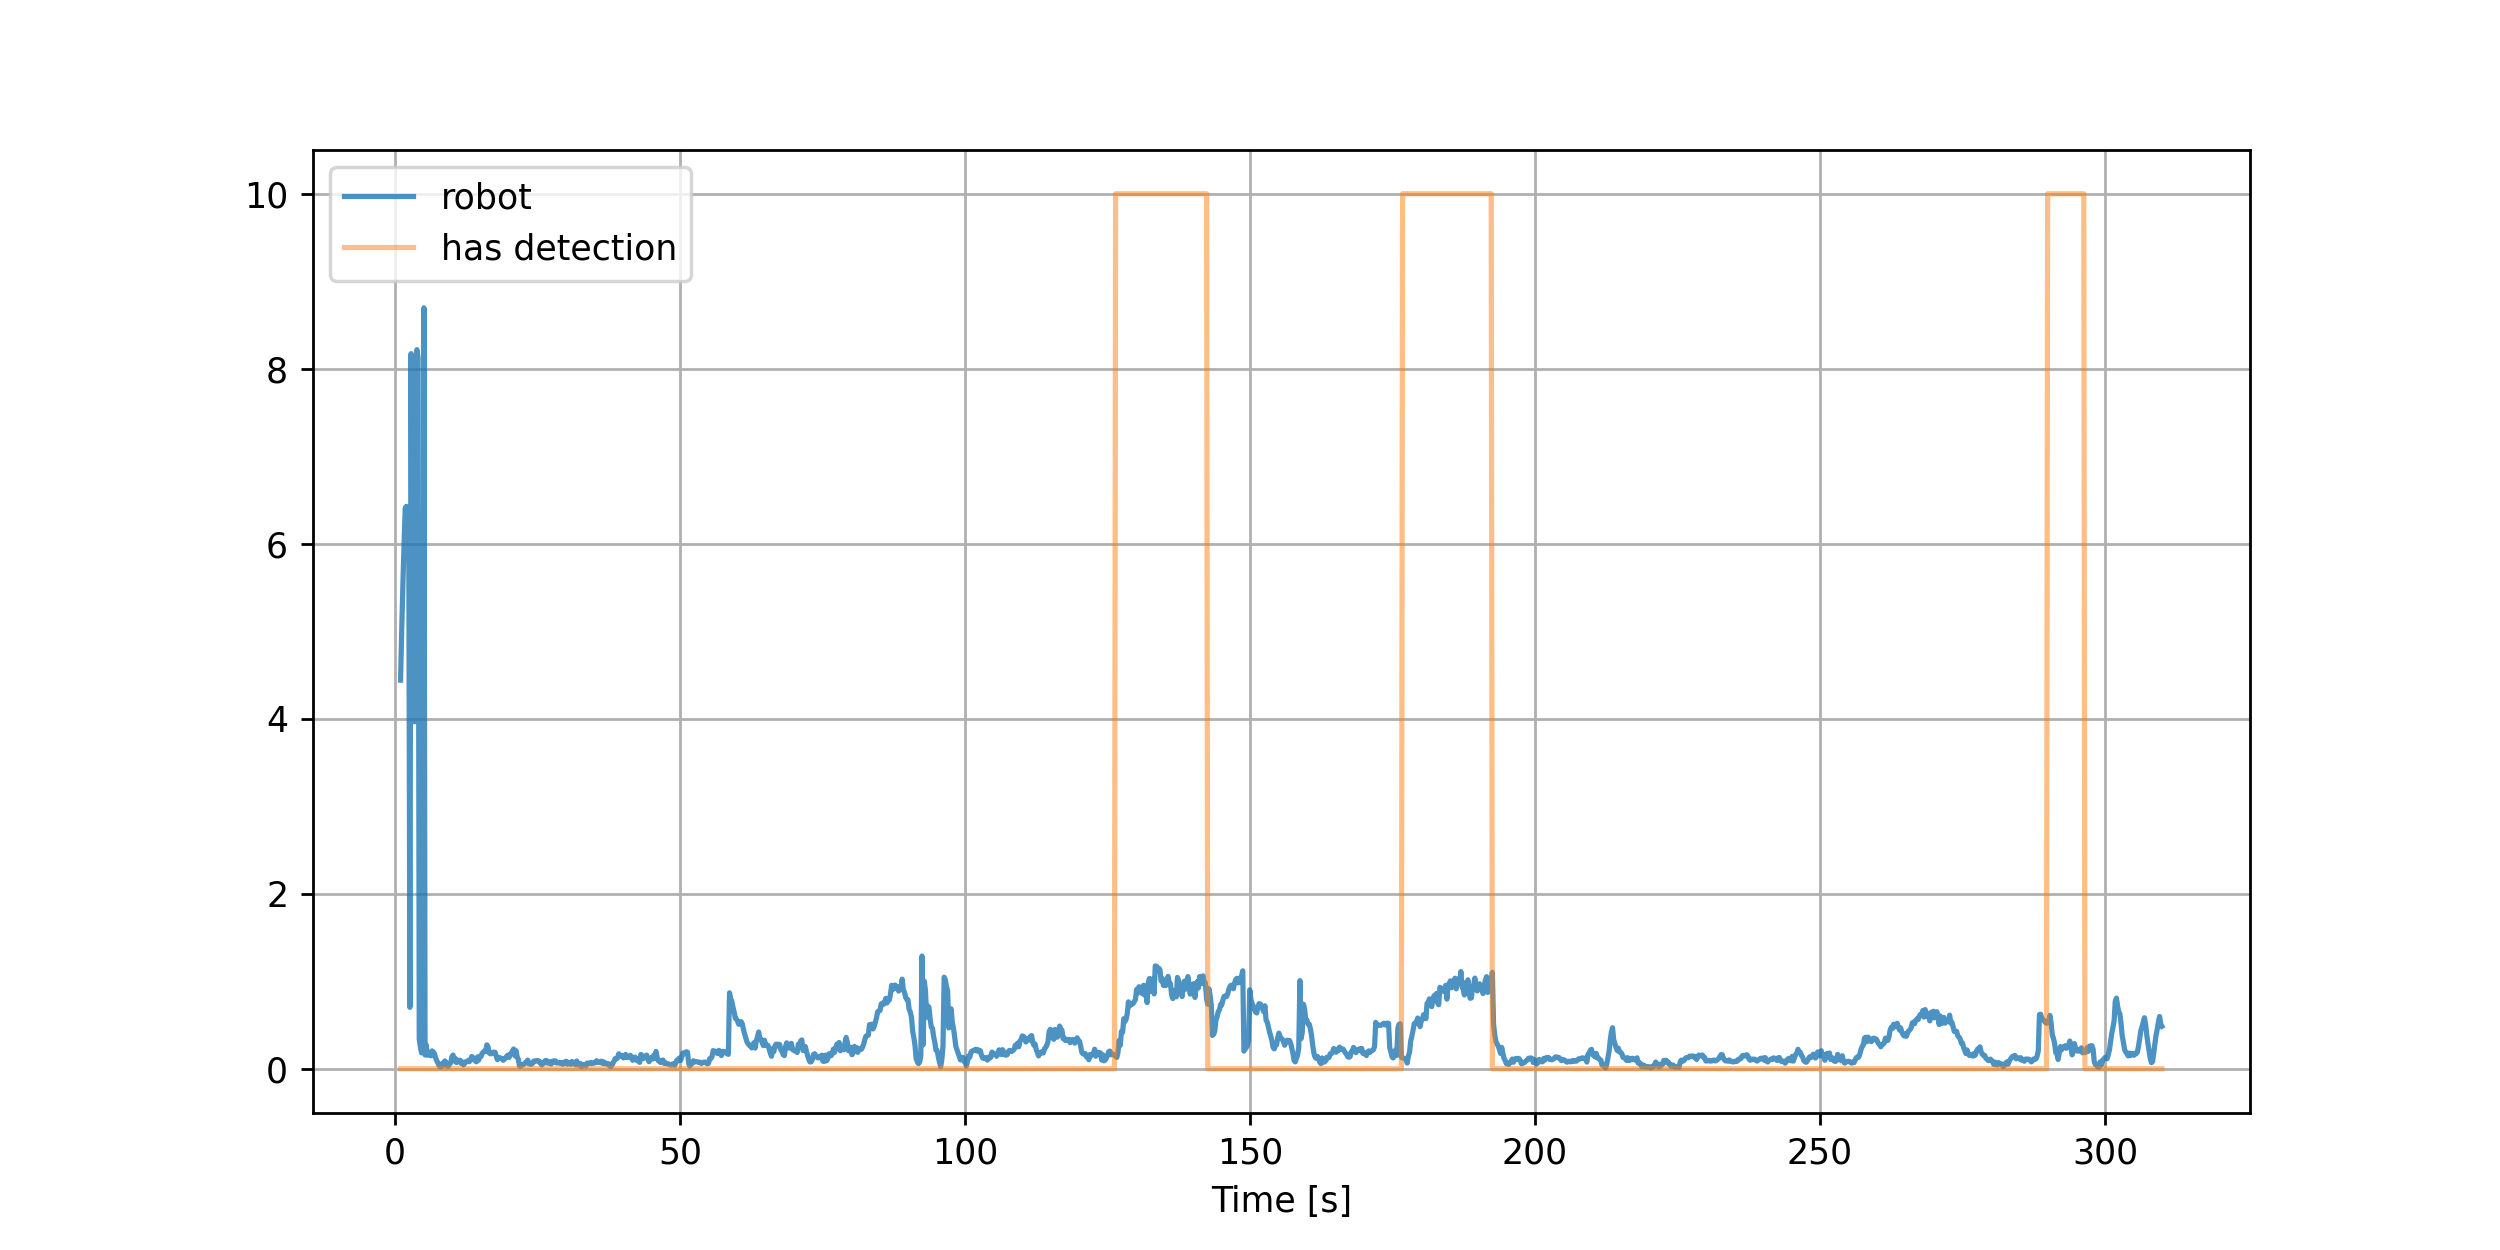

In [8]:
def plot_best_instantaneous_cluster_error(df):
    def _compute_best_cluster_and_its_error(row):
        best_cluster_id = np.argmax(row.filter(like='_weight'))
        row['best_cluster_id'] = best_cluster_id
        row['best_cluster_error'] = row[f'cluster{best_cluster_id}_error']
        return row 

    df = df.apply(_compute_best_cluster_and_its_error, axis=1)

    t = np.linspace(1, EXPERIMENT_TIME_S, len(df))

    plt.figure(figsize=(10, 5))
    plt.plot(t, _cells_to_meters(df['best_cluster_error']), alpha=0.8, label='robot')
    plt.plot(t, df.has_detection * 10, alpha=0.5, label="has detection")
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid()
    plt.show()

plot_best_instantaneous_cluster_error(df_robot1)
plot_best_instantaneous_cluster_error(df_robot2)

Done!